<b>LIBRARIES</b>

In [25]:
#Libraries required are initially imported
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#Keras for the model 
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array

<b>FUNCTIONS</b>

In [26]:
#Convert the image to a array of values indicating pixel colour range
def convert_image_to_array(image_dir):
    try:
        img = cv2.imread(image_dir)
        if img is not None :
            img = cv2.resize(img, default_image_size)   
            return img_to_array(img)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [27]:
#Function: used for prediction.
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

<b>DATA RETRIEVAL AND PROCESSING</b>

In [28]:
#Directory where the data is stored
directory_root = '../Dataset/archive/plantvillage/'

#Image specs
image_size = 0
width=256
height=256
depth=3

default_image_size = tuple((256, 256))

In [29]:
#Here we obtain the images from the different labelled folder.
image_list, label_list = [], []


try:
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"Folder {plant_disease_folder} processing done...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

Folder Tomato_Late_blight processing done...
Folder Tomato__Tomato_YellowLeaf__Curl_Virus processing done...
Folder Tomato_Septoria_leaf_spot processing done...
Folder Potato___Late_blight processing done...
Folder Tomato_healthy processing done...
Folder Tomato_Spider_mites_Two_spotted_spider_mite processing done...
Folder Pepper__bell___healthy processing done...
Folder Potato___Early_blight processing done...
Folder Tomato_Early_blight processing done...
Folder Tomato_Leaf_Mold processing done...
Folder Tomato__Target_Spot processing done...
Folder Tomato__Tomato_mosaic_virus processing done...
Folder Pepper__bell___Bacterial_spot processing done...
Folder Tomato_Bacterial_spot processing done...
Folder Potato___healthy processing done...
Image loading completed


In [30]:
#Transform Image Labels uisng Scikit Learn's LabelBinarizer : we obtain all the classes available
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)


In [31]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
#Now we split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

In [32]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [33]:
#Training specs
EPOCHS = 25
INIT_LR = 1e-3
BS = 32

<b>MODEL</b>

In [34]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 85, 85, 64)       

In [36]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
#Train the model
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

<b>PERFORMANCE ANALYSIS</b>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

<b>PKL file</b>

In [ ]:
# save the model to disk
pickle.dump(model,open('model.pkl', 'wb'))

<b>PREDICTION</b>

In [37]:
#Obtain the classes from the pkl file
filename = 'label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

/home/arathi/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
Pepper__bell___healthy


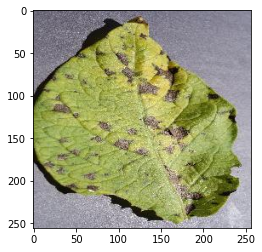

In [38]:
predict_disease('../Dataset/archive/PlantVillage/Potato___Early_blight/03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG')

In [ ]:
# # Get the current working directory
# cwd = os.getcwd()

# # Print the current working directory
# print("Current working directory: {0}".format(cwd))

Potato___Early_blight


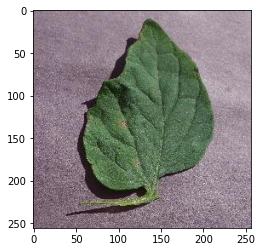

In [39]:
predict_disease('../Dataset/archive/PlantVillage/Tomato__Target_Spot/1006b3dd-22d8-41b8-b83d-08bf189fcdaa___Com.G_TgS_FL 8118.JPG')